# Fairness in Nodule Detection

Description: This notebook examines the profile of the SUMMIT sample (both in total and available) focusing on protected groups Age, Gender and Ethnicity. Informed by the composition of the sample, experiments are designed in order to show any bias when used to train a nodule detection algorithm.

In [18]:
# libraries
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import re
import seaborn as sns

workspace_path = Path(os.getcwd()).parent.parent


In [19]:
from re import T
import pandas as pd
from seaborn import heatmap
#utility functions
def crosstab_with_percentages(rows, columns, x_order=None, y_order=None, table=False, heatmap=False):
    # Create the crosstab with absolutes
    cols = [c.astype(str) for c in columns]
    rows = [r.astype(str) for r in rows]

    xabs = pd.crosstab(rows, cols).fillna(0)
    xperc = pd.crosstab(rows, cols, normalize='columns').fillna(0)

    if x_order:
        xabs = xabs.reindex(x_order, axis=1)
        xperc = xperc.reindex(x_order, axis=1)

    if y_order:
        xabs = xabs.reindex(y_order)
        xperc = xperc.reindex(y_order)

    combined_data = {}

    for (adx, rabs), (pdx, rperc) in zip(xabs.iterrows(), xperc.iterrows()):

        row_data = {}
        row_total = 0

        for col in xabs.columns:
            row_data[col] = f"{rabs[col]} ({rperc[col]:.1%})"
            row_total += rabs[col]

        row_data['Total'] = f'{row_total} ({row_total / xabs.sum().sum():.1%})'
        combined_data[adx] = row_data

    row_data = {}
    row_total = 0
    for col in xabs.columns:
        row_data[col] = f'{sum(xabs[col])}'
        row_total += xabs[col].sum()

    row_data['Total'] = row_total
    combined_data['Total'] = row_data

    if table:
        display(pd.DataFrame.from_dict(combined_data).T)
        
    
    if heatmap:
        sns.heatmap(xperc, annot=True, fmt=".1%", cmap='Blues')
        plt.show()

    return xperc, pd.DataFrame.from_dict(combined_data)

# Profile the data
def profile_sample(df, column='Available', table=False, heatmap=False):
    _, xgender = crosstab_with_percentages(
        [df.participant_details_gender],
        [df[column]],
        table=table,
        heatmap=heatmap
    )

    _, xage = crosstab_with_percentages(
        [df.participant_age_at_consent_cats],
        [df[column]],
        table=table,
        heatmap=heatmap
    )
    
    _, xethnic = crosstab_with_percentages(
        [df.lung_health_check_demographics_race_ethnicgroup],
        [df[column]],
        table=table,
        heatmap=heatmap
    )

    return pd.concat([xgender.drop('Total', axis=1), xage.drop('Total', axis=1), xethnic], axis=1).T

def show_heatmap_of_differences(df):
    
    df.fillna('0 (0%)', inplace=True)
    df.drop('Total', axis=0, inplace=True)
    heatmap_data = {}

    for idx, row in df.iterrows():
        total = float(re.search(r"\((.*?)%\)", row['Total']).group(1))

        heatmap_row = {}
        for col in row.index:
            if col != 'Total':
                val = float(re.search(r"\((.*?)%\)", row[col]).group(1))
                diff = val - total

                heatmap_row[col] = diff
        
        heatmap_data[idx] = heatmap_row

    sns.heatmap(
        pd.DataFrame.from_dict(heatmap_data).T, 
        center=0, vmin=-50, vmax=50,
        annot=True, cmap='RdBu')
    plt.show()

def combine_datasets_profiles(key, dataset_dict, heatmap=True):

    xuseable_trn = (
        profile_sample(dataset_dict['training'][key], 
        table=False, 
        heatmap=False)
        .drop('True', axis=1)
        .rename(columns={'Total':'Training'})
    )
    
    xuseable_val = (
        profile_sample(dataset_dict['validation'][key],
        table=False,
        heatmap=False)
        .drop('True', axis=1)
        .rename(columns={'Total':'Validation'})
    )

    xuseable_tst = (
        profile_sample(dataset_dict['test'][key], 
        table=False, 
        heatmap=False)
        .drop('True', axis=1)
        .rename(columns={'Total':'Test'})
    )

    xall  = (
        profile_sample(dataset_dict['total'], 
        table=False, 
        heatmap=False)
        .drop('True', axis=1)
    )

    xcombined = (
        pd.merge(xuseable_trn, xuseable_val, how='left', left_index=True, right_index=True)
        .merge(xuseable_tst, how='left', left_index=True, right_index=True)
        .merge(pd.DataFrame(xall, columns=['Total']), how='left', left_index=True, right_index=True)
    )

    display(xcombined)
    if heatmap:
        show_heatmap_of_differences(xcombined)

In [20]:
# SUMMIT Sample Composition

person_data = (
    pd.read_csv(f'{workspace_path}/data/summit/data/person_data.csv', low_memory=False)
    .assign(Available=lambda x: x.ScansTransfer_state == 'LUNG50=VEOLITY')
)

# All available SUMMIT data

,False,True,Total
FEMALE,3172 (45.2%),2338 (39.3%),5510 (42.5%)
MALE,3846 (54.8%),3605 (60.7%),7451 (57.5%)
55-59,1544 (22.0%),1220 (20.5%),2764 (21.3%)
60-64,1766 (25.2%),1474 (24.8%),3240 (25.0%)
65-69,1761 (25.1%),1531 (25.8%),3292 (25.4%)
70-75,1567 (22.3%),1398 (23.5%),2965 (22.9%)
75+,380 (5.4%),320 (5.4%),700 (5.4%)
Asian or Asian British,179 (2.6%),667 (11.2%),846 (6.5%)
Black,123 (1.8%),454 (7.6%),577 (4.5%)
Mixed,155 (2.2%),128 (2.2%),283 (2.2%)


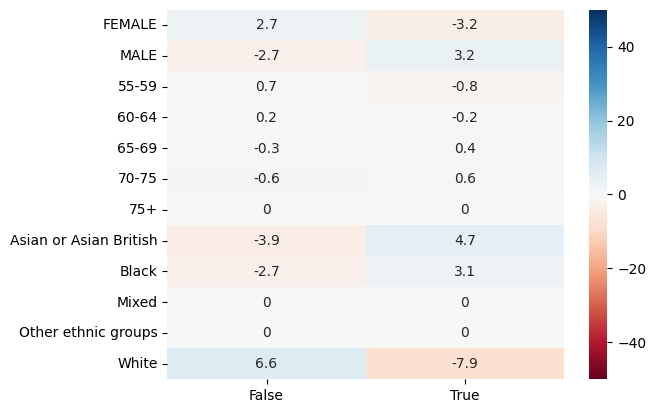

In [21]:
# Show protected characteristics by available sample
xcombined = profile_sample(person_data, table=False, heatmap=False)
display(xcombined)
show_heatmap_of_differences(xcombined)


In [22]:

# Check the protected groups by each other to see whether there is bias

xperc, xtab = crosstab_with_percentages(
    columns=[
        person_data.participant_age_at_consent_cats
    ],
    rows=[person_data.participant_details_gender],
    table=False,
    heatmap=False
)

display(xtab)

xperc, xtab = crosstab_with_percentages(
    columns=[person_data.lung_health_check_demographics_race_ethnicgroup],
    rows=[person_data.participant_details_gender],
    table=False,
    heatmap=False
)

display(xtab)

xperc, xtab = crosstab_with_percentages(
    columns=[person_data.participant_age_at_consent_cats],
    rows=[person_data.lung_health_check_demographics_race_ethnicgroup],
    table=False,
    heatmap=False
)

display(xtab)

,FEMALE,MALE,Total
55-59,1220 (44.1%),1544 (55.9%),2764
60-64,1349 (41.6%),1891 (58.4%),3240
65-69,1350 (41.0%),1942 (59.0%),3292
70-75,1277 (43.1%),1688 (56.9%),2965
75+,314 (44.9%),386 (55.1%),700
Total,5510 (42.5%),7451 (57.5%),12961


,FEMALE,MALE,Total
Asian or Asian British,72 (8.5%),774 (91.5%),846
Black,221 (38.3%),356 (61.7%),577
Mixed,132 (46.6%),151 (53.4%),283
Other ethnic groups,117 (25.9%),334 (74.1%),451
White,4968 (46.0%),5836 (54.0%),10804
Total,5510 (42.5%),7451 (57.5%),12961


,Asian or Asian British,Black,Mixed,Other ethnic groups,White,Total
55-59,180 (6.5%),163 (5.9%),86 (3.1%),118 (4.3%),2217 (80.2%),2764
60-64,238 (7.3%),150 (4.6%),90 (2.8%),146 (4.5%),2616 (80.7%),3240
65-69,244 (7.4%),152 (4.6%),74 (2.2%),96 (2.9%),2726 (82.8%),3292
70-75,137 (4.6%),89 (3.0%),29 (1.0%),80 (2.7%),2630 (88.7%),2965
75+,47 (6.7%),23 (3.3%),4 (0.6%),11 (1.6%),615 (87.9%),700
Total,846 (6.5%),577 (4.5%),283 (2.2%),451 (3.5%),10804 (83.4%),12961


(92, 0.0005460484544435718)


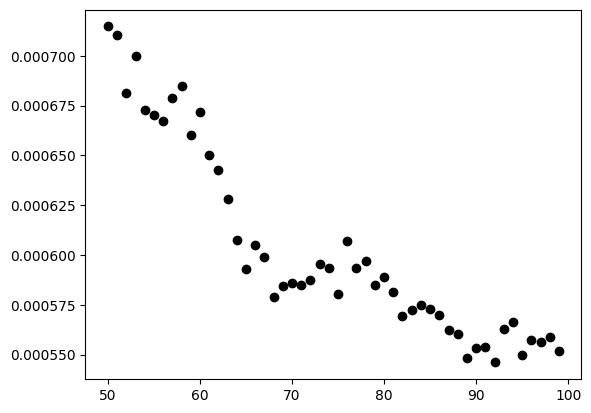

In [23]:
from itertools import product
from sklearn.metrics import mean_squared_error


def get_percentages(data):
    combinations = list(product(
        data.participant_details_gender.unique(),
        data.lung_health_check_demographics_race_ethnicgroup.unique()
    ))

    percentages = {}
    for combination in combinations:
        
        subset = data[
            (data.participant_details_gender == combination[0]) &
            (data.lung_health_check_demographics_race_ethnicgroup == combination[1])
        ]

        percentages[combination] = len(subset) / len(data)
    return pd.DataFrame.from_dict(percentages, orient='index', columns=['p'])

def get_mse(target, output):

    data = pd.merge(target, output, left_index=True, right_index=True, suffixes=('_target', '_output'))
    return mean_squared_error(data.p_target, data.p_output)

target = get_percentages(person_data)

results = {}
for frac in range(50, 100, 1):
    subsample = person_data.sample(frac=frac/100, random_state=42)
    output = get_percentages(subsample[subsample.Available])

    mse = get_mse(target, output)

    results[frac] = mse

    plt.scatter(frac, mse, color='black')

lowest_mse_entry = min(results.items(), key=lambda x: x[1])
print(lowest_mse_entry)

## Justification for using all rather than pulling out optimal sample
The lowest mse error is so close to the 100% sample selection point that it doesnt make sens to remove a handful of cases for training to try to align as the skew will persist!

,Training,Validation,Test,Total
FEMALE,1865 (39.2%),110 (37.0%),361 (40.5%),5510 (42.5%)
MALE,2887 (60.8%),187 (63.0%),530 (59.5%),7451 (57.5%)
55-59,963 (20.3%),63 (21.2%),194 (21.8%),2764 (21.3%)
60-64,1174 (24.7%),98 (33.0%),202 (22.7%),3240 (25.0%)
65-69,1246 (26.2%),58 (19.5%),226 (25.4%),3292 (25.4%)
70-75,1109 (23.3%),61 (20.5%),227 (25.5%),2965 (22.9%)
75+,260 (5.5%),17 (5.7%),42 (4.7%),700 (5.4%)
Asian or Asian British,509 (10.7%),41 (13.8%),116 (13.0%),846 (6.5%)
Black,372 (7.8%),17 (5.7%),65 (7.3%),577 (4.5%)
Mixed,101 (2.1%),7 (2.4%),20 (2.2%),283 (2.2%)


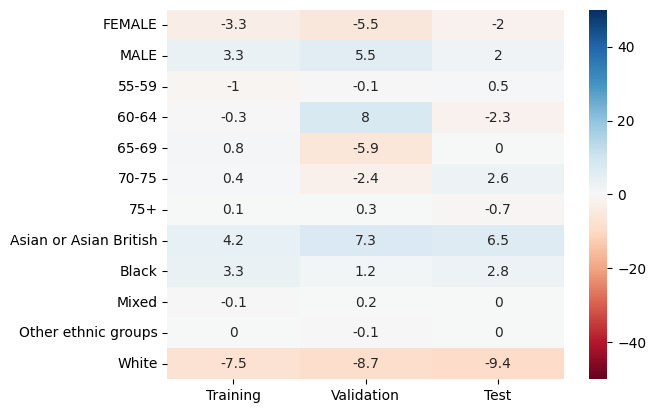

In [24]:

training_data = pd.read_csv(f'{workspace_path}/metadata/summit/partial/training_scans_metadata.csv', low_memory=False).assign(Available=True)
validation_data = pd.read_csv(f'{workspace_path}/metadata/summit/partial/validation_scans_metadata.csv', low_memory=False).assign(Available=True)
test_data = pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_scans_metadata.csv', low_memory=False).assign(Available=True)


datasets = {
    'total' : person_data,
    'training' : 
    {
        'partial' : training_data
    },
    'validation' : 
    {
        'partial' : validation_data
    },
    'test' : 
    {
        'partial' : test_data
    }
}

combine_datasets_profiles('partial', datasets)

## Update: Need to rework sample

When this sample was trained & evaluated on SUMMIT the numbers in the protected groups was so low that it was not possible to get a decent confidence interval to be confident of the results.

Therefore in order to reduce the confidence interval this next experiment will be to increase the Test cases for the protected groups whilst maintaining the best balance possible for the rest of the training.

The following work generates the Trn, Val & Tst datasets along those lines.

Original test dataset count: 891
New test dataset count: 594
White - male: 39
White - female: 159
Asian: 198
Black: 198
Mixed: 0
Other: 0


/tmp/ipykernel_936685/2075972023.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  available_data.loc[test_data.index, 'dataset'] = 'test'


,Training,Validation,Test,Total
FEMALE,1963 (38.6%),125 (46.8%),250 (42.1%),5510 (42.5%)
MALE,3119 (61.4%),142 (53.2%),344 (57.9%),7451 (57.5%)
55-59,1033 (20.3%),52 (19.5%),135 (22.7%),2764 (21.3%)
60-64,1267 (24.9%),59 (22.1%),148 (24.9%),3240 (25.0%)
65-69,1295 (25.5%),71 (26.6%),165 (27.8%),3292 (25.4%)
70-75,1214 (23.9%),70 (26.2%),114 (19.2%),2965 (22.9%)
75+,273 (5.4%),15 (5.6%),32 (5.4%),700 (5.4%)
Asian or Asian British,444 (8.7%),25 (9.4%),198 (33.3%),846 (6.5%)
Black,244 (4.8%),12 (4.5%),198 (33.3%),577 (4.5%)
Mixed,119 (2.3%),9 (3.4%),NaN,283 (2.2%)


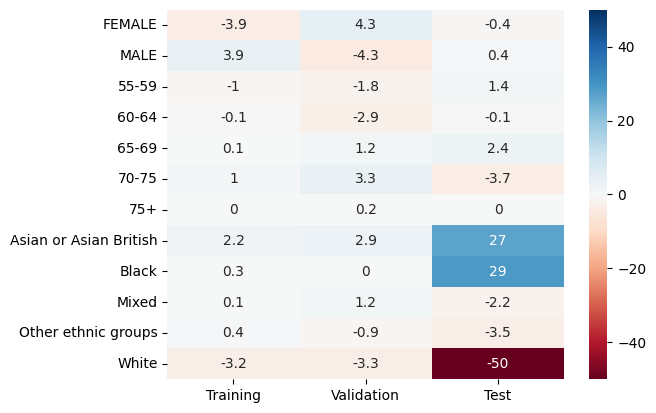

,Asian or Asian British,Black,White,Total
FEMALE,22 (11.1%),69 (34.8%),159 (80.3%),250 (42.1%)
MALE,176 (88.9%),129 (65.2%),39 (19.7%),344 (57.9%)
Total,198,198,198,594


In [25]:

def value_counts_with_percentages(series):
    vc = series.value_counts()
    vcp = series.value_counts(normalize=True)
    vc = pd.concat([vc, vcp], axis=1)
    return vc


e_white_cnt = 665
e_asian_cnt = 108
e_black_cnt = 65
e_mixed_cnt = 19
e_other_cnt = 34
total = e_white_cnt + e_asian_cnt + e_black_cnt + e_mixed_cnt + e_other_cnt

print('Original test dataset count:', total)

# reworkiing to fix Asian & Black counts as 200

e_asian_cnt = 198
e_black_cnt = 198
e_mixed_cnt = 0
e_other_cnt = 0
total = 198 * 3

e_white_cnt = total - (e_asian_cnt + e_black_cnt + e_mixed_cnt + e_other_cnt)

e_white_male_cnt = int(e_white_cnt*0.20)
e_white_female_cnt = e_white_cnt - e_white_male_cnt

print('New test dataset count:', total)
print('White - male:', e_white_male_cnt)
print('White - female:', e_white_female_cnt)
print('Asian:', e_asian_cnt)
print('Black:', e_black_cnt)
print('Mixed:', e_mixed_cnt)
print('Other:', e_other_cnt)

available_data = person_data[person_data.Available]


ethnic_black = available_data.lung_health_check_demographics_race_ethnicgroup=='Black'
ethnic_asian = available_data.lung_health_check_demographics_race_ethnicgroup=='Asian or Asian British'
ethnic_white = available_data.lung_health_check_demographics_race_ethnicgroup=='White'
ethnic_mixed = available_data.lung_health_check_demographics_race_ethnicgroup=='Mixed'
ethnic_other = available_data.lung_health_check_demographics_race_ethnicgroup=='Other ethnic groups'

gender_male = available_data.participant_details_gender=='MALE'
gender_female = available_data.participant_details_gender=='FEMALE'


black_tst = available_data[ethnic_black].sample(n=e_black_cnt, random_state=42)
asian_tst = available_data[ethnic_asian].sample(n=e_asian_cnt, random_state=42)
white_male_tst = available_data[ethnic_white&gender_male].sample(n=e_white_male_cnt, random_state=42)
white_female_tst = available_data[ethnic_white&gender_female].sample(n=e_white_female_cnt, random_state=42)
mixed_tst = available_data[ethnic_mixed].sample(n=e_mixed_cnt, random_state=42)
other_tst = available_data[ethnic_other].sample(n=e_other_cnt, random_state=42)

test_data = pd.concat([black_tst, asian_tst, white_male_tst, white_female_tst, mixed_tst, other_tst])

training_data = available_data.drop(test_data.index).sample(frac=0.95, random_state=42)
validation_data = available_data.drop(test_data.index).drop(training_data.index)


available_data.loc[test_data.index, 'dataset'] = 'test'
available_data.loc[training_data.index, 'dataset'] = 'training'
available_data.loc[validation_data.index, 'dataset'] = 'validation'


datasets['training']['test_balanced'] = training_data
datasets['validation']['test_balanced'] = validation_data
datasets['test']['test_balanced'] = test_data

_ = combine_datasets_profiles('test_balanced', datasets)


_ = crosstab_with_percentages(
    rows=[datasets['test']['test_balanced'].participant_details_gender],
    columns=[datasets['test']['test_balanced'].lung_health_check_demographics_race_ethnicgroup],
    table=True
)


In [26]:
import json

recode = {
       'radiology_report_nodule_brock_score' : 'nodule_brock_score',
       'radiology_report_nodule_category' : 'nodule_category',
       'radiology_report_nodule_diameter_mm' : 'nodule_diameter_mm',
       'radiology_report_nodule_lesion_id' : 'nodule_lesion_id',
       'radiology_report_nodule_lung_rads' : 'nodule_lung_rads',
       'radiology_report_nodule_mass' : 'nodule_mass',
       'radiology_report_nodule_mass_core' : 'nodule_mass_core',
       'radiology_report_nodule_mass_double_time_core' : 'nodule_mass_double_time_core',
       'radiology_report_nodule_mass_doubling_time' : 'nodule_mass_doubling_time',
       'radiology_report_nodule_reliable_segment' : 'nodule_reliable_segment',
       'radiology_report_nodule_site' : 'nodule_site',
       'radiology_report_nodule_size_volume_cub_mm' : 'nodule_size_volume_cub_mm',
       'radiology_report_nodule_slice_number' : 'nodule_slice_number',
       'radiology_report_nodule_spiculation' : 'nodule_spiculation',
       'radiology_report_nodule_subsolid_major_axis_diameter' : 'nodule_subsolid_major_axis_diameter',
       'radiology_report_nodule_type' : 'nodule_type',
       'radiology_report_nodule_volume_core' : 'nodule_volume_core',
       'radiology_report_nodule_volume_doubling_time' : 'nodule_volume_doubling_time',
       'radiology_report_nodule_volume_percentage_change' : 'nodule_volume_percentage_change',
       'radiology_report_nodule_volume_volume_double_time_core' : 'nodule_volume_volume_double_time_core',
       'radiology_report_nodule_x_coordinate': 'nodule_x_coordinate',
       'radiology_report_nodule_y_coordinate': 'nodule_y_coordinate',
       'radiology_report_nodule_z_coordinate' : 'nodule_z_coordinate',
       'radiology_report_management_plan' : 'management_plan',
       'participant_details_gender' : 'gender',
       'participant_age_at_consent_cats' : 'age_group',
       'lung_health_check_demographics_race_ethnicgroup' : 'ethnic_group'
}

scan_metadata = (
    pd.read_csv(f'{workspace_path}/data/summit/data/person_data.csv', low_memory=False)
    .drop('Unnamed: 0', axis=1)
    .assign(scan_id=lambda x: x.LDCT_RADIOLOGY_REPORT_main_participant_id + '_Y0_BASELINE_A')
)

scan_metadata = scan_metadata[~scan_metadata.LDCT_RADIOLOGY_REPORT_main_participant_id.isin(['summit-9754-pkv','summit-2625-nvf','summit-6242-zvz'])]

nodule_data = (
    pd.read_csv(f'{workspace_path}/data/summit/data/nodule_data.csv', low_memory=False)
    .rename(columns=recode)
    .drop('Unnamed: 0', axis=1)
)

nodule_data = nodule_data[~nodule_data.participant_id.isin(['summit-9754-pkv','summit-2625-nvf','summit-6242-zvz'])]
nodule_data = nodule_data[nodule_data.nodule_type!='ENDOBRONCHIAL']

for ds in ['training','validation','test']:
    
    study_ids = datasets[ds]['test_balanced'].LDCT_RADIOLOGY_REPORT_main_participant_id.values
    
    scan_metadata[scan_metadata.LDCT_RADIOLOGY_REPORT_main_participant_id.isin(study_ids)]['scan_id'].to_csv(f'{workspace_path}/metadata/summit/test_balanced/{ds}_scans.csv', index=False)
    scan_metadata[scan_metadata.LDCT_RADIOLOGY_REPORT_main_participant_id.isin(study_ids)].to_csv(f'{workspace_path}/metadata/summit/test_balanced/{ds}_scans_metadata.csv', index=False)
    nodule_data[nodule_data.participant_id.isin(study_ids)&~nodule_data.radiology_report_lesions_to_exclude].to_csv(f'{workspace_path}/metadata/summit/test_balanced/{ds}_metadata.csv', index=False)
    nodule_data[nodule_data.participant_id.isin(study_ids)&nodule_data.radiology_report_lesions_to_exclude].to_csv(f'{workspace_path}/metadata/summit/test_balanced/{ds}_excludes.csv', index=False)

# Check counts etc

for ds in ['training','validation','test']:
    for f in ['scans','scans_metadata','metadata','excludes']:
        print(f'{ds} {f}:', len(pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/{ds}_{f}.csv', low_memory=False)))


# Now create MONAI Detection json files
dataset_dict = {'training':[], 'test' : []}

for ds in ['training', 'validation', 'test']:
    scan_ids = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/{ds}_scans.csv', low_memory=False).scan_id.values
    metadata = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/{ds}_metadata.csv', low_memory=False).assign(scan_id=lambda x: x.participant_id + '_Y0_BASELINE_A')

    for scan_id in scan_ids:

        scan_dict = {
            'box' : [],
            'image' : f'{scan_id.replace("_Y0_BASELINE_A","")}/{scan_id}.nii.gz',
            'label' : []
        } 

        for idx, row in metadata[metadata.scan_id == scan_id].iterrows():
            scan_dict['box'].append([
                row.nodule_x_coordinate,
                row.nodule_y_coordinate,
                row.nodule_z_coordinate,
                row.nodule_diameter_mm,
                row.nodule_diameter_mm,
                row.nodule_diameter_mm
            ])
            scan_dict['label'].append(0)

        if ds == 'training' or ds == 'validation':
            if len(scan_dict['box']) > 0:
                dataset_dict['training'].append(scan_dict)

        elif ds == 'test':
            dataset_dict['test'].append(scan_dict)


# check number of images and boxes in each dataset
for ds in ['training', 'test']:
    print('*'*20)
    print(f'{ds} images:', len(dataset_dict[ds]))
    print(f'{ds} boxes:', sum([len(scan['box']) for scan in dataset_dict[ds]]))


with open(f'{workspace_path}/models/detection/datasplits/summit/test_balanced/dataset_test_balanced.json', 'w') as f:
    json.dump(dataset_dict, f, indent=4)


training scans: 5079
training scans_metadata: 5079
training metadata: 6541
training excludes: 1446
validation scans: 267
validation scans_metadata: 267
validation metadata: 377
validation excludes: 80
test scans: 594
test scans_metadata: 594
test metadata: 699
test excludes: 162
********************
training images: 3004
training boxes: 6918
********************
test images: 594
test boxes: 699


# Balanced datasets

## Gender
- Use all FEMALE and match same number of MALES for Training and Validation; leave hold-out unchanged




,Training,Validation,Test,Total
FEMALE,1865 (50.0%),110 (50.0%),361 (40.5%),5510 (42.5%)
MALE,1865 (50.0%),110 (50.0%),530 (59.5%),7451 (57.5%)
55-59,756 (20.3%),48 (21.8%),194 (21.8%),2764 (21.3%)
60-64,924 (24.8%),70 (31.8%),202 (22.7%),3240 (25.0%)
65-69,970 (26.0%),40 (18.2%),226 (25.4%),3292 (25.4%)
70-75,875 (23.5%),45 (20.5%),227 (25.5%),2965 (22.9%)
75+,205 (5.5%),17 (7.7%),42 (4.7%),700 (5.4%)
Asian or Asian British,338 (9.1%),24 (10.9%),116 (13.0%),846 (6.5%)
Black,283 (7.6%),12 (5.5%),65 (7.3%),577 (4.5%)
Mixed,90 (2.4%),5 (2.3%),20 (2.2%),283 (2.2%)


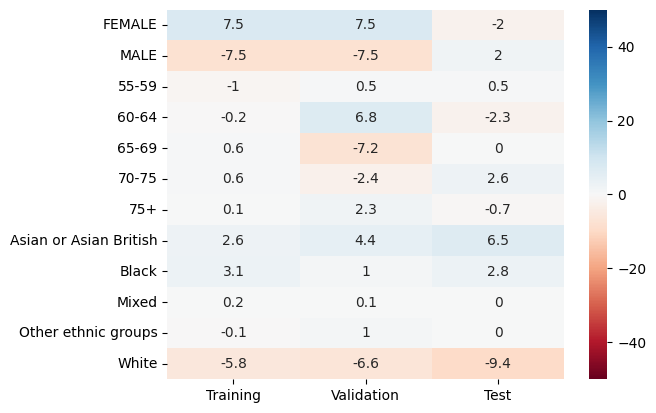

In [27]:

for k, ds in datasets.items():
 
    if k == 'total':
        continue

    data = ds['partial']
    if k in ['training', 'validation']:
        female = data[data.participant_details_gender == 'FEMALE']
        male = data[data.participant_details_gender=='MALE'].sample(female.shape[0], random_state=42)
        gender_balanced = pd.concat([female, male])

    else:
        gender_balanced = data

    datasets[k]['gender_balanced'] = gender_balanced

combine_datasets_profiles('gender_balanced', datasets)

## Ethnicity

,Training,Validation,Test,Total
FEMALE,310 (27.8%),17 (33.3%),361 (40.5%),5510 (42.5%)
MALE,806 (72.2%),34 (66.7%),530 (59.5%),7451 (57.5%)
55-59,255 (22.8%),11 (21.6%),194 (21.8%),2764 (21.3%)
60-64,277 (24.8%),14 (27.5%),202 (22.7%),3240 (25.0%)
65-69,320 (28.7%),14 (27.5%),226 (25.4%),3292 (25.4%)
70-75,205 (18.4%),11 (21.6%),227 (25.5%),2965 (22.9%)
75+,59 (5.3%),1 (2.0%),42 (4.7%),700 (5.4%)
Asian or Asian British,372 (33.3%),17 (33.3%),116 (13.0%),846 (6.5%)
Black,372 (33.3%),17 (33.3%),65 (7.3%),577 (4.5%)
White,372 (33.3%),17 (33.3%),659 (74.0%),10804 (83.4%)


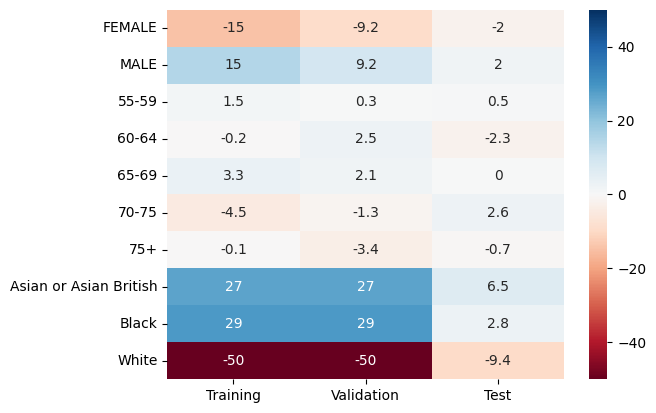

In [28]:
for k, ds in datasets.items():
 
    if k == 'total':
        continue

    data = ds['partial']
    if k in ['training', 'validation']:
        black = data[data.lung_health_check_demographics_race_ethnicgroup=='Black']
        asian = data[data.lung_health_check_demographics_race_ethnicgroup=='Asian or Asian British'].sample(black.shape[0], random_state=42)
        white = data[data.lung_health_check_demographics_race_ethnicgroup=='White'].sample(black.shape[0], random_state=42)
        ethnicity_balanced = pd.concat([black, asian, white])

    else:
        ethnicity_balanced = data

    datasets[k]['ethnicity_balanced'] = ethnicity_balanced

combine_datasets_profiles('ethnicity_balanced', datasets)

# 1-class ethnicity training & evaluation

- create 10 datasets:
    - 100% black
    - 100% asian
    - 8 * 100% white

    

One class 0


,Training,Validation,Test,Total
FEMALE,146 (39.2%),7 (41.2%),361 (40.5%),5510 (42.5%)
MALE,226 (60.8%),10 (58.8%),530 (59.5%),7451 (57.5%)
55-59,105 (28.2%),6 (35.3%),194 (21.8%),2764 (21.3%)
60-64,96 (25.8%),5 (29.4%),202 (22.7%),3240 (25.0%)
65-69,97 (26.1%),1 (5.9%),226 (25.4%),3292 (25.4%)
70-75,55 (14.8%),4 (23.5%),227 (25.5%),2965 (22.9%)
75+,19 (5.1%),1 (5.9%),42 (4.7%),700 (5.4%)
Black,372 (100.0%),17 (100.0%),65 (7.3%),577 (4.5%)
Total,372,17,891,12961


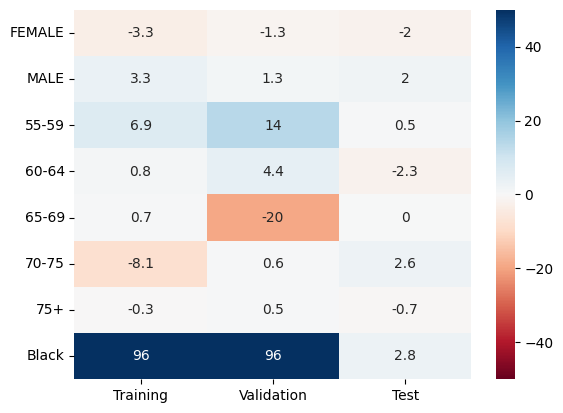

One class 1


,Training,Validation,Test,Total
FEMALE,45 (8.8%),6 (14.6%),361 (40.5%),5510 (42.5%)
MALE,464 (91.2%),35 (85.4%),530 (59.5%),7451 (57.5%)
55-59,108 (21.2%),4 (9.8%),194 (21.8%),2764 (21.3%)
60-64,136 (26.7%),16 (39.0%),202 (22.7%),3240 (25.0%)
65-69,146 (28.7%),16 (39.0%),226 (25.4%),3292 (25.4%)
70-75,87 (17.1%),4 (9.8%),227 (25.5%),2965 (22.9%)
75+,32 (6.3%),1 (2.4%),42 (4.7%),700 (5.4%)
Asian or Asian British,509 (100.0%),41 (100.0%),116 (13.0%),846 (6.5%)
Total,509,41,891,12961


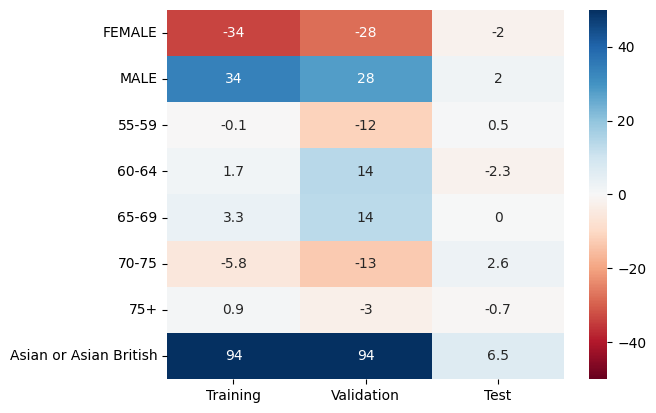

One class 2


,Training,Validation,Test,Total
FEMALE,134 (36.0%),8 (47.1%),361 (40.5%),5510 (42.5%)
MALE,238 (64.0%),9 (52.9%),530 (59.5%),7451 (57.5%)
55-59,71 (19.1%),2 (11.8%),194 (21.8%),2764 (21.3%)
60-64,84 (22.6%),5 (29.4%),202 (22.7%),3240 (25.0%)
65-69,111 (29.8%),5 (29.4%),226 (25.4%),3292 (25.4%)
70-75,89 (23.9%),5 (29.4%),227 (25.5%),2965 (22.9%)
75+,17 (4.6%),NaN,42 (4.7%),700 (5.4%)
White,372 (100.0%),17 (100.0%),659 (74.0%),10804 (83.4%)
Total,372,17,891,12961


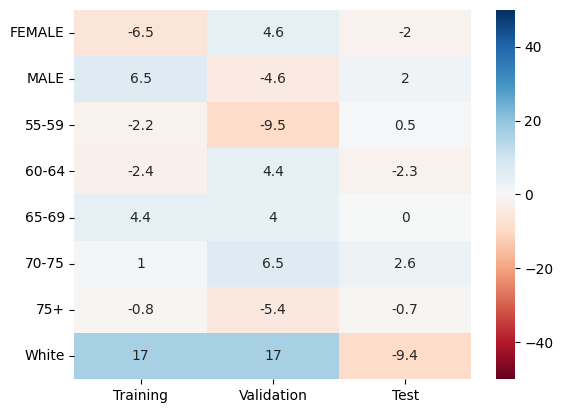

One class 3


,Training,Validation,Test,Total
FEMALE,174 (46.8%),9 (52.9%),361 (40.5%),5510 (42.5%)
MALE,198 (53.2%),8 (47.1%),530 (59.5%),7451 (57.5%)
55-59,62 (16.7%),NaN,194 (21.8%),2764 (21.3%)
60-64,89 (23.9%),9 (52.9%),202 (22.7%),3240 (25.0%)
65-69,100 (26.9%),4 (23.5%),226 (25.4%),3292 (25.4%)
70-75,101 (27.2%),3 (17.6%),227 (25.5%),2965 (22.9%)
75+,20 (5.4%),1 (5.9%),42 (4.7%),700 (5.4%)
White,372 (100.0%),17 (100.0%),659 (74.0%),10804 (83.4%)
Total,372,17,891,12961


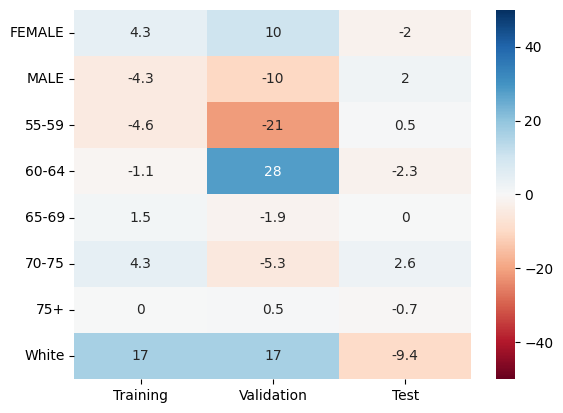

One class 4


,Training,Validation,Test,Total
FEMALE,160 (43.0%),6 (35.3%),361 (40.5%),5510 (42.5%)
MALE,212 (57.0%),11 (64.7%),530 (59.5%),7451 (57.5%)
55-59,70 (18.8%),3 (17.6%),194 (21.8%),2764 (21.3%)
60-64,99 (26.6%),6 (35.3%),202 (22.7%),3240 (25.0%)
65-69,104 (28.0%),3 (17.6%),226 (25.4%),3292 (25.4%)
70-75,82 (22.0%),2 (11.8%),227 (25.5%),2965 (22.9%)
75+,17 (4.6%),3 (17.6%),42 (4.7%),700 (5.4%)
White,372 (100.0%),17 (100.0%),659 (74.0%),10804 (83.4%)
Total,372,17,891,12961


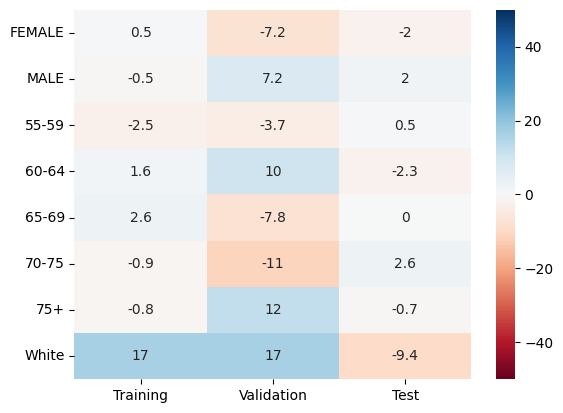

One class 5


,Training,Validation,Test,Total
FEMALE,178 (47.8%),4 (23.5%),361 (40.5%),5510 (42.5%)
MALE,194 (52.2%),13 (76.5%),530 (59.5%),7451 (57.5%)
55-59,63 (16.9%),3 (17.6%),194 (21.8%),2764 (21.3%)
60-64,89 (23.9%),2 (11.8%),202 (22.7%),3240 (25.0%)
65-69,102 (27.4%),3 (17.6%),226 (25.4%),3292 (25.4%)
70-75,96 (25.8%),8 (47.1%),227 (25.5%),2965 (22.9%)
75+,22 (5.9%),1 (5.9%),42 (4.7%),700 (5.4%)
White,372 (100.0%),17 (100.0%),659 (74.0%),10804 (83.4%)
Total,372,17,891,12961


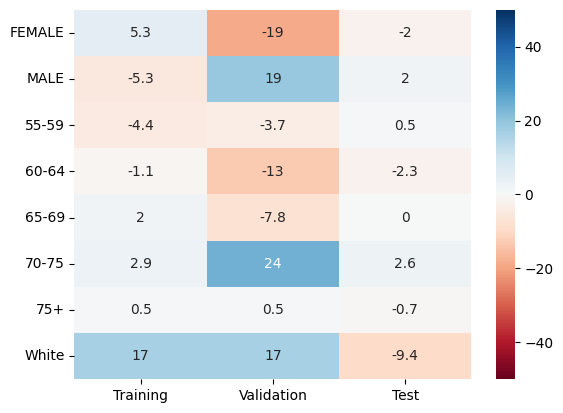

One class 6


,Training,Validation,Test,Total
FEMALE,177 (47.6%),8 (47.1%),361 (40.5%),5510 (42.5%)
MALE,195 (52.4%),9 (52.9%),530 (59.5%),7451 (57.5%)
55-59,73 (19.6%),4 (23.5%),194 (21.8%),2764 (21.3%)
60-64,88 (23.7%),7 (41.2%),202 (22.7%),3240 (25.0%)
65-69,94 (25.3%),2 (11.8%),226 (25.4%),3292 (25.4%)
70-75,97 (26.1%),3 (17.6%),227 (25.5%),2965 (22.9%)
75+,20 (5.4%),1 (5.9%),42 (4.7%),700 (5.4%)
White,372 (100.0%),17 (100.0%),659 (74.0%),10804 (83.4%)
Total,372,17,891,12961


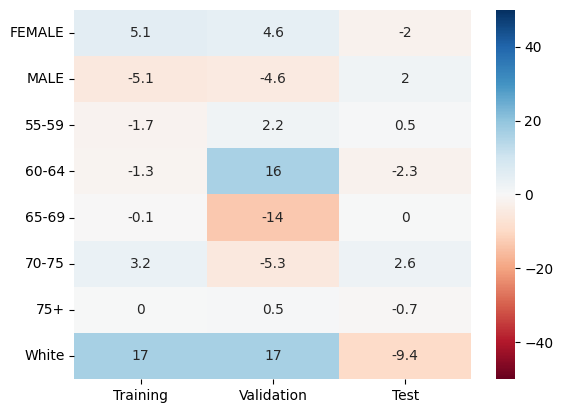

One class 7


,Training,Validation,Test,Total
FEMALE,172 (46.2%),4 (23.5%),361 (40.5%),5510 (42.5%)
MALE,200 (53.8%),13 (76.5%),530 (59.5%),7451 (57.5%)
55-59,65 (17.5%),3 (17.6%),194 (21.8%),2764 (21.3%)
60-64,80 (21.5%),6 (35.3%),202 (22.7%),3240 (25.0%)
65-69,100 (26.9%),4 (23.5%),226 (25.4%),3292 (25.4%)
70-75,106 (28.5%),3 (17.6%),227 (25.5%),2965 (22.9%)
75+,21 (5.6%),1 (5.9%),42 (4.7%),700 (5.4%)
White,372 (100.0%),17 (100.0%),659 (74.0%),10804 (83.4%)
Total,372,17,891,12961


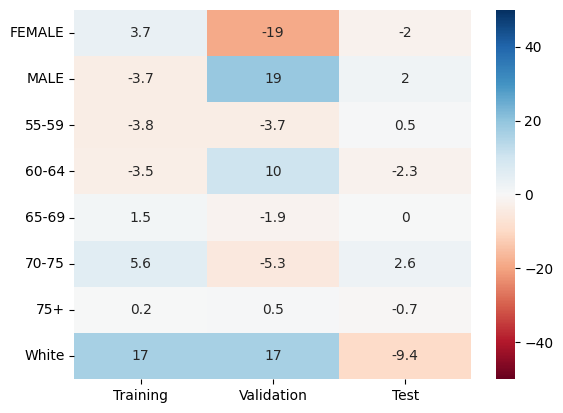

One class 8


,Training,Validation,Test,Total
FEMALE,156 (41.9%),8 (47.1%),361 (40.5%),5510 (42.5%)
MALE,216 (58.1%),9 (52.9%),530 (59.5%),7451 (57.5%)
55-59,70 (18.8%),7 (41.2%),194 (21.8%),2764 (21.3%)
60-64,88 (23.7%),5 (29.4%),202 (22.7%),3240 (25.0%)
65-69,96 (25.8%),2 (11.8%),226 (25.4%),3292 (25.4%)
70-75,89 (23.9%),3 (17.6%),227 (25.5%),2965 (22.9%)
75+,29 (7.8%),NaN,42 (4.7%),700 (5.4%)
White,372 (100.0%),17 (100.0%),659 (74.0%),10804 (83.4%)
Total,372,17,891,12961


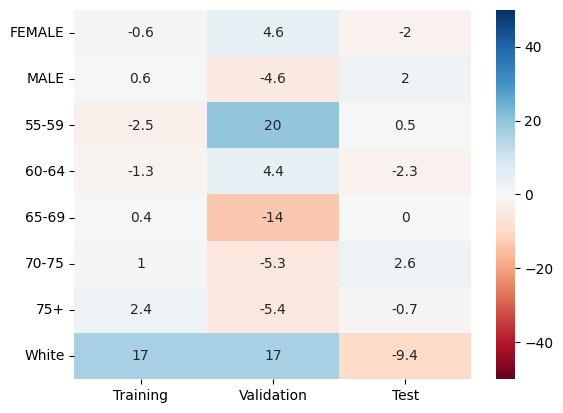

One class 9


,Training,Validation,Test,Total
FEMALE,155 (41.7%),9 (52.9%),361 (40.5%),5510 (42.5%)
MALE,217 (58.3%),8 (47.1%),530 (59.5%),7451 (57.5%)
55-59,63 (16.9%),4 (23.5%),194 (21.8%),2764 (21.3%)
60-64,88 (23.7%),5 (29.4%),202 (22.7%),3240 (25.0%)
65-69,81 (21.8%),4 (23.5%),226 (25.4%),3292 (25.4%)
70-75,111 (29.8%),3 (17.6%),227 (25.5%),2965 (22.9%)
75+,29 (7.8%),1 (5.9%),42 (4.7%),700 (5.4%)
White,372 (100.0%),17 (100.0%),659 (74.0%),10804 (83.4%)
Total,372,17,891,12961


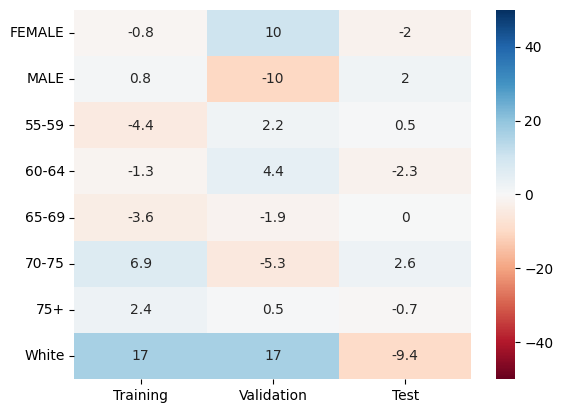

In [29]:

from seaborn import heatmap


data = person_data[person_data.Available]

for k, ds in datasets.items():
     
        if k == 'total':
            continue
    
        data = ds['partial']

        one_class_datasets = []
        if k in ['training', 'validation']:
            one_class_datasets.append(data[data.lung_health_check_demographics_race_ethnicgroup=='Black'])
            one_class_datasets.append(data[data.lung_health_check_demographics_race_ethnicgroup=='Asian or Asian British'])
            ds2_ds9 = data[data.lung_health_check_demographics_race_ethnicgroup=='White']

            for i in range(2, 10):
                one_class_datasets.append(ds2_ds9.sample(one_class_datasets[0].shape[0], random_state=42))
                ds2_ds9 = ds2_ds9.drop(one_class_datasets[i].index)

        else:
            for i in range(10):
                one_class_datasets.append(data)

        for i in range(0, 10):
            datasets[k][f'one_class_{i}'] = one_class_datasets[i]


for i in range(0, 10):

    print(f'One class {i}')
    combine_datasets_profiles(f'one_class_{i}', datasets)


In [30]:
import numpy as np

image = np.load('/Users/john/Projects/SOTAEvaluationNoduleDetection/cache/sota/summit/summit-2397-yhy_Y0_BASELINE_A_clean.npy')
print(image.shape)

for idx in range(0,image.shape[1], 20):
    plt.imshow(image[0,idx,:,:], cmap='gray')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/john/Projects/SOTAEvaluationNoduleDetection/cache/sota/summit/summit-2397-yhy_Y0_BASELINE_A_clean.npy'